In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from giggle.data import (
    DATASETS,
)

from giggle.recommender import (
    load_recommender,
)

In [3]:
# Helper functions
def read_file(path):
    with open(path, 'r') as f:
        return f.read()
    
DATA_PATH = '../data'

def get_joke_path(joke_id):
    return os.path.join(DATA_PATH, 'jokes', str(joke_id) + '.txt')

In [4]:
# Load data
dataset = DATASETS["large"]()

# Baseline recommender

Implements a model of the form $b_{ui} = \mu + b_u + b_i,$ where:

* $b_{ui}$ is the baseline estimate for rating $r_{ui}$
* $b_u$ and $b_i$ indicate the observed deviations of user $u$ and item $i$
* $\mu$ is the average rating

In [5]:
reco = load_recommender("../data/models/baseline.pkl")

## Baselines for jokes

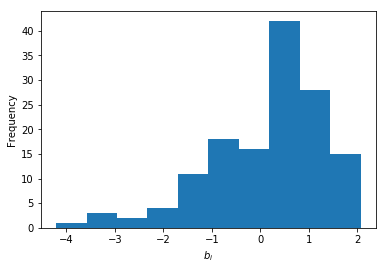

In [6]:
b_joke = list(reco.b_joke.values())
plt.hist(b_joke)
plt.xlabel('$b_i$')
plt.ylabel('Frequency')

### Funniest joke

In [7]:
most_funny_joke_id = max(reco.b_joke, key=reco.b_joke.get)
print("ID:", most_funny_joke_id)
print()
print(read_file(get_joke_path(most_funny_joke_id)))

ID: 21

What's the difference between a used tire and 365 used condoms?

One's a Goodyear, the other's a great year.


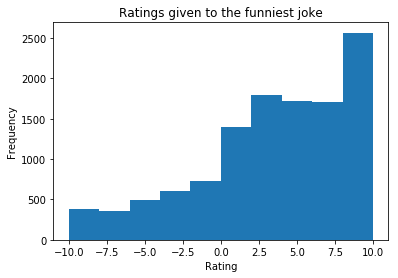

In [8]:
idxs = dataset.data_frame.joke_id == most_funny_joke_id
plt.hist(dataset.data_frame[idxs].rating)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Ratings given to the funniest joke')

### Least funny joke

In [9]:
least_funny_joke_id = min(reco.b_joke, key=reco.b_joke.get)
print(read_file(get_joke_path(least_funny_joke_id)))

How many feminists does it take to screw in a light bulb?

That's not funny.


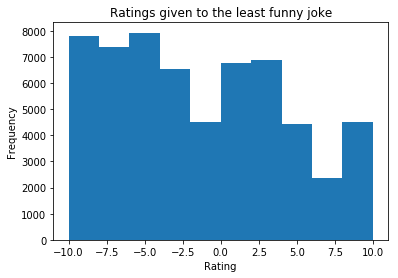

In [10]:
idxs = dataset.data_frame.joke_id == least_funny_joke_id
plt.hist(dataset.data_frame[idxs].rating)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Ratings given to the least funny joke')

# Baselines for users

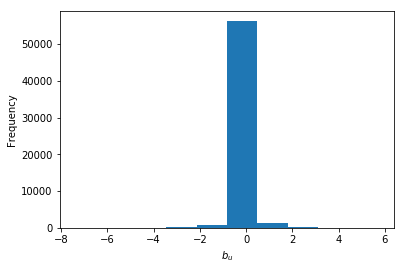

In [11]:
b_user = list(reco.b_user.values())
plt.hist(b_user)
plt.xlabel('$b_u$')
plt.ylabel('Frequency')

### Most indulgent user

6112 5.75235538641


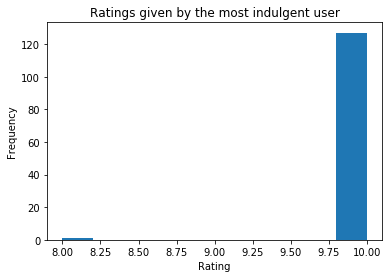

In [12]:
most_indulgent_user_id = max(reco.b_user, key=reco.b_user.get)
print(most_indulgent_user_id, reco.b_user[most_indulgent_user_id])
idxs = dataset.data_frame.user_id == most_indulgent_user_id
plt.hist(dataset.data_frame[idxs].rating)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Ratings given by the most indulgent user')

### Most critical user

1751 -7.40204918043


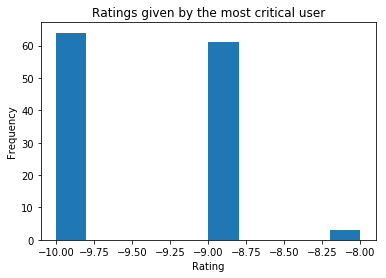

In [13]:
most_critical_user_id = min(reco.b_user, key=reco.b_user.get)
print(most_critical_user_id, reco.b_user[most_critical_user_id])
idxs = dataset.data_frame.user_id == most_critical_user_id
plt.hist(dataset.data_frame[idxs].rating)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Ratings given by the most critical user')

# Item-based neighbourhood model

In [14]:
reco = load_recommender("../data/models/neigh.pkl")

-0.0219550235441 1.0


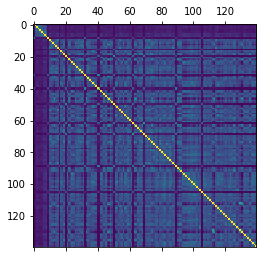

In [15]:
print(reco.sims.min(), reco.sims.max())
plt.matshow(reco.sims)

In [16]:
idxs = np.argsort(-reco.sims[reco.data.joke_to_iid[21]])
idxs = idxs[1:6]
for i in idxs:
    print("ID:", i)
    print()
    print(read_file(get_joke_path(i)))
    print()

ID: 15

Q: What did the blind person say when given some matzah?

A: Who the hell wrote this?

ID: 114

Sherlock Holmes and Dr. Watson go on a camping trip, set up their tent, and fall asleep. Some hours later, Holmes wakes his faithful friend. "Watson, look up at the sky and tell me what you see." 

Watson replies, "I see millions of stars." 

"What does that tell you?" 

Watson ponders for a minute. "Astronomically speaking, it tells me that there are millions of galaxies and potentially billions of planets. Astrologically, it tells me that Saturn is in Leo. Timewise, it appears to be approximately a quarter past three. Theologically, it's evident the Lord is all-powerful and we are small and insignificant. Meteorologically, it seems we will have a beautiful day tomorrow. What does it tell you?" 

Holmes is silent for a moment, then speaks. "Watson, you idiot, someone has stolen our tent."

ID: 72

On the first day of college, the Dean addressed the students, pointing out some of the

# Performance comparison

| Method | RMSE |
|------|------|
| Guassian | |
| Baseline | |
| Neighbourhood | |

# Error analysis